# Noise Reduction Using PCA and Autoencoders

Hiva Abolhadizadeh 400405004 \
Machine Learning Course Autumn semester
By Dr. Mahdi Eftekhari  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load the Fashion MNIST Dataset and Add Noise

1. Load the Fashion MNIST dataset: The dataset contains 28x28 grayscale
images of clothing items. Normalize the images to a range of [0, 1] to prepare
for further processing.

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.10MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



2. Add Gaussian noise: To simulate noisy images, add Gaussian noise to the
images. This will introduce random noise into the images to test the
effectiveness of noise reduction methods.

In [5]:
# Add Gaussian noise to images
def add_noise(images, noise_factor=0.4):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clip(noisy_images, -1.0, 1.0)
    return noisy_images

In [7]:
def add_simple_noise(images, std_dev=0.1):
    noisy_images = images + torch.randn_like(images) * std_dev
    noisy_images = torch.clip(noisy_images, -1.0, 1.0)
    return noisy_images

In [5]:
# Visualize some examples of train data and noisy data
def visualize_train_noisy_examples():
    train_images, _ = next(iter(train_loader))
    noisy_images = add_noise(train_images)

    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        # Original images
        axes[0, i].imshow(train_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Noisy images
        axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Noisy")

    plt.tight_layout()
    plt.show()

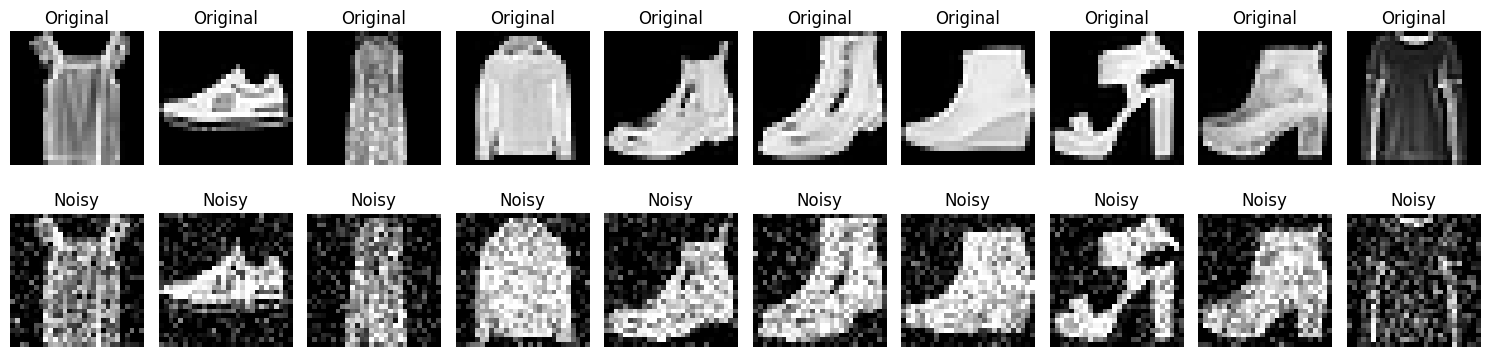

In [6]:
visualize_train_noisy_examples()

## Step 2: PCA Implementation for Noise Reduction

1. Flatten the images into vectors: Convert the 28x28 images into 1D vectors
(784 dimensions) to apply PCA.

In [12]:
def flatten_images(images):
    # Check if input is a 4D tensor with shape (batch_size, 1, height, width)
    if images.ndim != 4 or images.size(1) != 1:
        raise ValueError("Input images must be a 4D tensor with shape (batch_size, 1, height, width).")

    # Check if images are normalized within the range [-1, 1]
    if images.min() < -1.0 or images.max() > 1.0:
        raise ValueError("Input images must be normalized to the range [-1, 1].")

    # Flatten the images
    return images.view(images.size(0), -1).numpy()


2. Apply PCA: Use PCA to compute the top k principal components of the noisy
data. These components will capture the most important features of the
images.

In [36]:
def compute_pca(data, n_components):
    #center
    mean = np.mean(data, axis=0)
    centered_data = data - mean

    #covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    #eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

    return mean, top_eigenvectors

3. Reconstruct the images: Reconstruct the images using these top components,
effectively reducing the noise in the images by discarding the less important
components.

In [37]:
def pca_reconstruction(images, n_components=100):
    images_flattened = flatten_images(images)
    mean, components = compute_pca(images_flattened, n_components)

    # Project data onto principal components
    projected_data = np.dot(images_flattened - mean, components)

    # Reconstruct data
    reconstructed_data = np.dot(projected_data, components.T) + mean

    # Convert back to PyTorch tensor and reshape to original dimensions
    return torch.tensor(reconstructed_data, dtype=torch.float32).view(-1, 1, 28, 28)

## Step 3: Autoencoder Implementation for Noise Reduction

1. Define the autoencoder architecture: Create an encoder that compresses the
input image and a decoder that reconstructs it back to its original size.

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the images
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed.view(-1, 1, 28, 28)

In [22]:
#!pip -q install torchviz

In [23]:
from torchviz import make_dot
autoencoder = Autoencoder()
x = torch.randn(1, 1, 28, 28)
output = autoencoder(x)
make_dot(output, params=dict(autoencoder.named_parameters())).render("autoencoder", format="png")

'autoencoder.png'

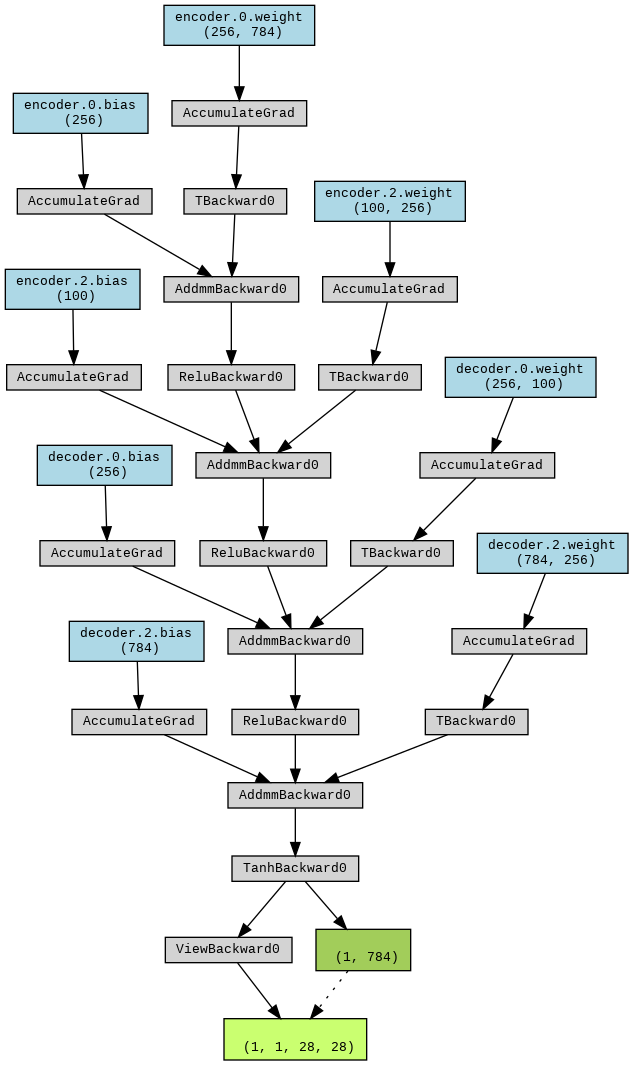

This Model consists of an encoder that compresses
28
×
28
 images into a 100-dimensional latent representation and a decoder that reconstructs the images from this compressed representation. The model uses fully connected layers with ReLU activation in the encoder and decoder, with a final Tanh activation to normalize the output. This structure enables efficient compression and reconstruction, making it effective for noise reduction tasks.

In [12]:
# Initialize autoencoder, loss function, and optimizer
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

2. Train the autoencoder: Use noisy images as input and clean images as target
outputs for training. The model will learn to reconstruct the clean images from
the noisy ones.

In [13]:
n_epochs = 10
def train_autoencoder():
    autoencoder.train()
    for epoch in range(n_epochs):
        for images, _ in train_loader:
            noisy_images = add_noise(images)
            optimizer.zero_grad()
            outputs = autoencoder(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

In [14]:
train_autoencoder()

Epoch [1/10], Loss: 0.0480
Epoch [2/10], Loss: 0.0514
Epoch [3/10], Loss: 0.0368
Epoch [4/10], Loss: 0.0471
Epoch [5/10], Loss: 0.0421
Epoch [6/10], Loss: 0.0359
Epoch [7/10], Loss: 0.0419
Epoch [8/10], Loss: 0.0448
Epoch [9/10], Loss: 0.0330
Epoch [10/10], Loss: 0.0326


## Step 4: Compare Results

In [15]:
def find_best_n_components(images, variance_threshold=0.95):
    images_flattened = flatten_images(images)

    # Center the data
    mean = np.mean(images_flattened, axis=0)
    centered_data = images_flattened - mean

    # Compute covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Eigen decomposition
    eigenvalues, _ = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    # Compute cumulative explained variance
    cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

    # Find the number of components that explain the desired variance
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Number of components to retain {variance_threshold * 100:.0f}% variance: {n_components}")
    return n_components, cumulative_variance


In [16]:
def evaluate_reconstruction_error(images, max_components=100):
    images_flattened = flatten_images(images)

    # Center the data
    mean = np.mean(images_flattened, axis=0)
    centered_data = images_flattened - mean

    errors = []
    for n in range(1, max_components + 1):
        _, components = compute_pca(images_flattened, n)
        projected_data = np.dot(centered_data, components)
        reconstructed_data = np.dot(projected_data, components.T) + mean

        # Compute reconstruction error (mean squared error)
        mse = np.mean((images_flattened - reconstructed_data) ** 2)
        errors.append(mse)

    return errors

In [17]:
def plot_reconstruction_error(images):
    max_components = 100
    errors = evaluate_reconstruction_error(images, max_components)
    print(min(errors))
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_components + 1), errors, marker='o')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Reconstruction Error vs. Number of Components")
    plt.grid()
    plt.show()

Number of components to retain 95% variance: 36
1.169433564995694e-15


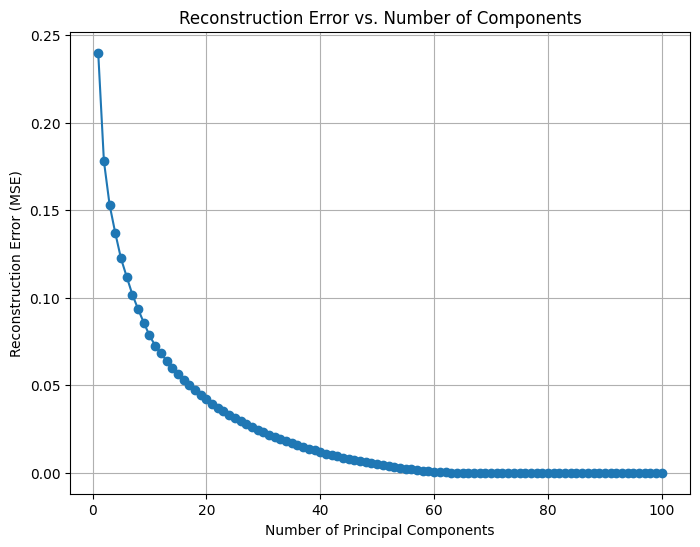

In [48]:
train_images, _ = next(iter(train_loader))

# Step 1: Find the approximate number of components for 95% variance
n_components, cumulative_variance = find_best_n_components(train_images, variance_threshold=0.95)

# Step 2: Plot reconstruction error to refine selection
plot_reconstruction_error(train_images)


In [19]:
from sklearn.decomposition import PCA

In [71]:
def advanced_pca_denoise(noisy_images, threshold=0.95):
    images_flattened = flatten_images(noisy_images)

    pca = PCA()
    pca.fit(images_flattened)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= threshold) + 1

    pca_reduced = PCA(n_components=n_components)
    pca_data = pca_reduced.fit_transform(images_flattened)
    reconstructed_data = pca_reduced.inverse_transform(pca_data)

    return torch.tensor(reconstructed_data, dtype=torch.float32).view(-1, 1, 28, 28)


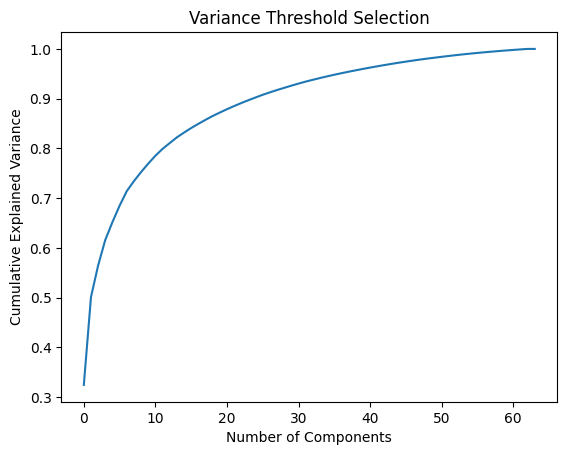

In [93]:
def find_variance_threshold(noisy_images):
    images_flattened = flatten_images(noisy_images)
    pca = PCA()
    pca.fit(images_flattened)

    # Plot cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Threshold Selection')
    plt.show()

    return cumulative_variance

# Visualize and manually choose threshold
variance_curve = find_variance_threshold(noisy_images)

In [60]:
def visualize_results():
    autoencoder.eval()
    test_images, _ = next(iter(test_loader))
    noisy_images = add_noise(test_images)
    pca_denoised = pca_reconstruction(noisy_images, n_components=36)
    pca_denoised_sk = pca_reconstruction_sklearn(noisy_images,54)
    with torch.no_grad():
        autoencoder_denoised = autoencoder(noisy_images)

    # Original Images
    print("\n" + "="*50)
    print("Original Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

    # Noisy Images
    print("\n" + "="*50)
    print("Noisy Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

    # PCA Denoised Images
    print("\n" + "="*50)
    print("PCA Denoised Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(pca_denoised[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()
        # PCA sckit Denoised Images
    print("\n" + "="*50)
    print("PCA sckit Denoised Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(pca_denoised_sk[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

    # Autoencoder Denoised Images
    print("\n" + "="*50)
    print("Autoencoder Denoised Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(autoencoder_denoised[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

In [82]:
def select_components(variance_curve, thresholds=[0.90, 0.95, 0.99]):
    components_dict = {}
    for threshold in thresholds:
        n_components = np.argmax(variance_curve >= threshold) + 1
        components_dict[threshold] = n_components
    return components_dict

# Find number of components for different thresholds
component_counts = select_components(variance_curve)
print(component_counts)

{0.9: 41, 0.95: 50, 0.99: 60}



Original Images:


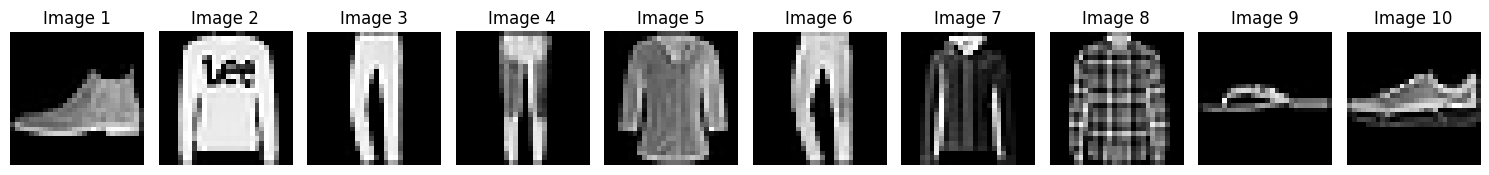


Noisy Images:


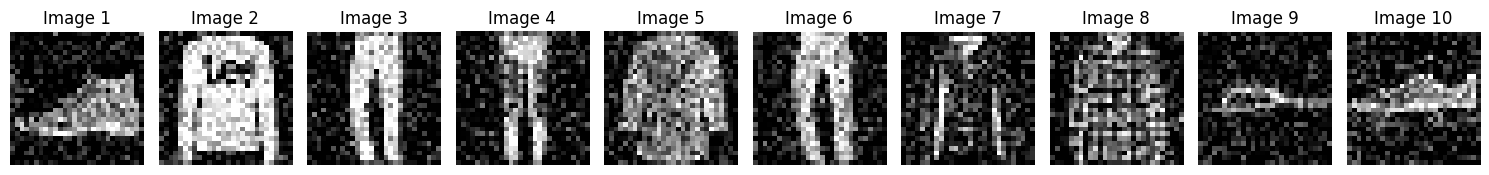


PCA Denoised Images:


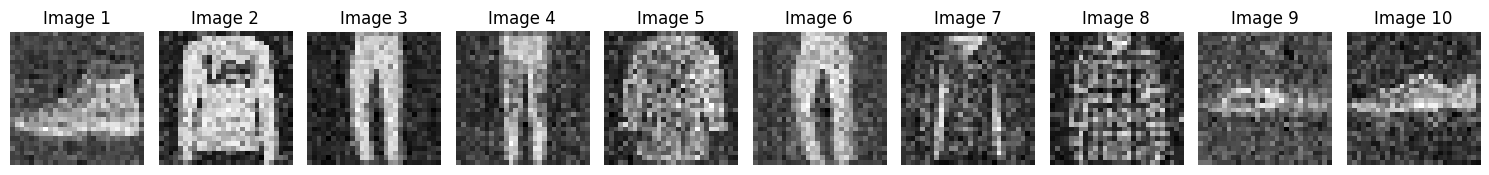


PCA sckit Denoised Images:


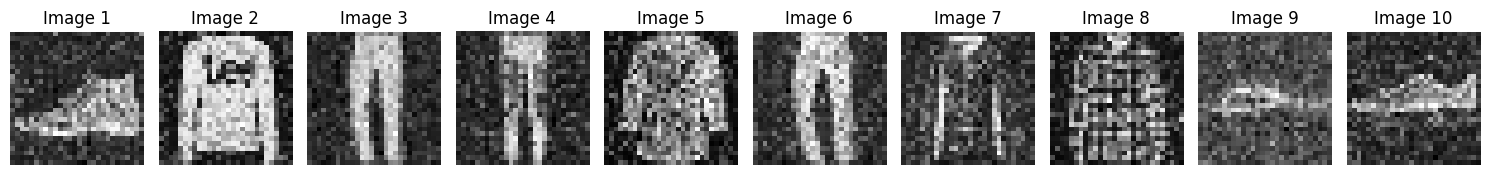


Autoencoder Denoised Images:


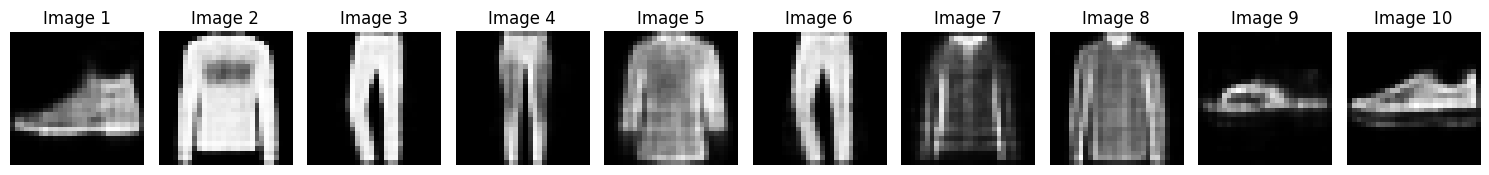

In [61]:
visualize_results()

In [8]:
test_images, _ = next(iter(test_loader))
noisy_images = add_simple_noise(test_images)

In [94]:
pca_denoised_test = advanced_pca_denoise(noisy_images, 0.95)


Noisy Images:


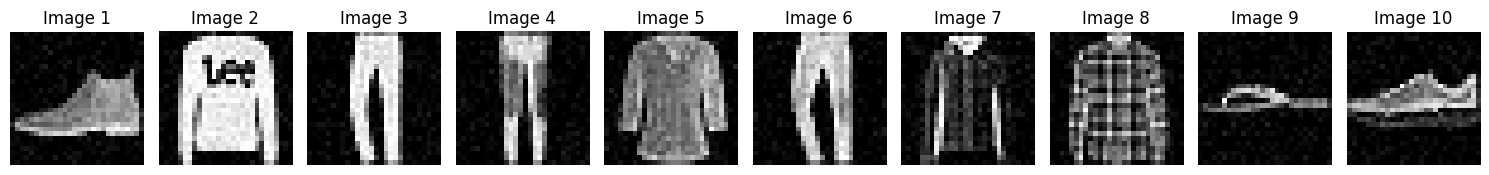

In [96]:
    # Noisy Images
    print("\n" + "="*50)
    print("Noisy Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()


PCA sckit Denoised Images:


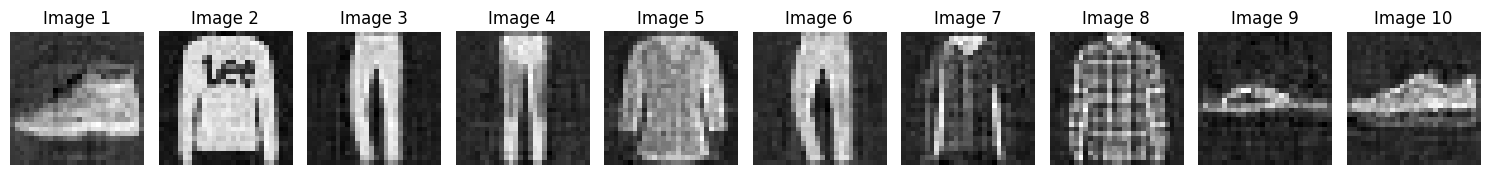

In [95]:
    print("\n" + "="*50)
    print("PCA sckit Denoised Images:")
    print("="*50)
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(pca_denoised_test[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()